In [1]:
# OVERFITTING AND UNDERFITTING: REGULARIZATION AND DROPOUT
# Improve movie review classifier

from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow and Keras through TensorFlow
import tensorflow as tf
from tensorflow import keras

# Import helper libraries
import numpy as np
# Print the array entirely
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-rc0


In [2]:
### Load the dataset

NUM_WORDS = 10000

# The words with an index above NUM_WORDS are replace by <UNK>
(X_train, Y_train), (X_test, Y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

# Each review is a list of index
# Each index correspond to a word in the dictionary
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [3]:
# Let's use a multi-hot encoding for the reviews

def multi_hot_sequences(sequences, dimension):
    ''' Convert a list of m reviews into a list of (m, NUM_WORDS).
        Each row vector contains 0/1 values. A value of 1 means that
        the word corresponding to the index value is contained in the sentence.
    '''
    
    # Initialize the output
    output = np.zeros((len(sequences), dimension))
    for sequence_index, words_indices in enumerate(sequences):
        # Set the word index to 1.0 since it is contained in the sentence
        output[sequence_index, words_indices] = 1.0 
    return output

In [4]:
# Let's convert the training/test set in multi-hot reviews

X_train = multi_hot_sequences(X_train, NUM_WORDS)
X_test = multi_hot_sequences(X_test, NUM_WORDS)

# Check the 1st training example
print(X_train[0])

[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

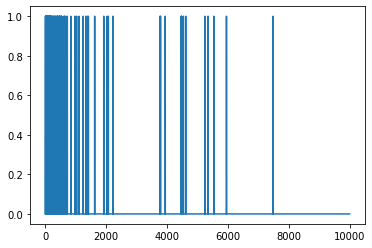

In [5]:
# Let's plot the 1st training example

plt.plot(X_train[0])
plt.show()

# Notice that the word indices are sorted by frequency,
# That is why there are many 1-value close to the index 0

In [6]:
# 1st solution to address overfitting: Simplify the network
# With few parameters, the resulting hypothesis learned will be simpler
# -> Experiment several network architectures

# Let's start by implementing a simple network.
# Then, add more units/layers to reduce the cost on the validation set.

# INPUT(m, NUM_WORDS) -> DENSE(16) -> RELU -> DENSE(16) -> RELU -> DENSE(1) -> SIGMOID 

initial_model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

initial_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

initial_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Let's train the model

initial_model_history = initial_model.fit(X_train,
                                          Y_train,
                                          epochs=20,
                                          batch_size=512,
                                          validation_data=(X_test, Y_test), # Use the test set as the validation set
                                          verbose=2)

W0907 12:12:51.217090 140735803462528 deprecation.py:323] From /Users/nicolas/anaconda/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 8s - loss: 0.4759 - accuracy: 0.8015 - binary_crossentropy: 0.4759 - val_loss: 0.3221 - val_accuracy: 0.8808 - val_binary_crossentropy: 0.3221
Epoch 2/20
25000/25000 - 4s - loss: 0.2390 - accuracy: 0.9138 - binary_crossentropy: 0.2390 - val_loss: 0.2857 - val_accuracy: 0.8863 - val_binary_crossentropy: 0.2857
Epoch 3/20
25000/25000 - 3s - loss: 0.1793 - accuracy: 0.9366 - binary_crossentropy: 0.1793 - val_loss: 0.2976 - val_accuracy: 0.8820 - val_binary_crossentropy: 0.2976
Epoch 4/20
25000/25000 - 3s - loss: 0.1407 - accuracy: 0.9522 - binary_crossentropy: 0.1407 - val_loss: 0.3172 - val_accuracy: 0.8793 - val_binary_crossentropy: 0.3172
Epoch 5/20
25000/25000 - 3s - loss: 0.1147 - accuracy: 0.9620 - binary_crossentropy: 0.1147 - val_loss: 0.3538 - val_accuracy: 0.8719 - val_binary_crossentropy: 0.3538
Epoch 6/20
25000/25000 - 3s - loss: 0.0964 - accuracy: 0.9693 - binary_crossentropy: 0.0964 - val_loss: 0.3987

In [8]:
# Notice 'overfitting' phenomena: train_accuracy = 1, validation_accuracy = 0.86

# Let's create a smaller model to try to address 'overfitting'
# INPUT(m, NUM_WORDS) -> DENSE(4) -> RELU -> DENSE(4) -> RELU -> DENSE(1) -> SIGMOID 

small_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

small_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])

small_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Let's train the small model using the same data

small_model_history = small_model.fit(X_train,
                                      Y_train,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data = (X_test, Y_test),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 5s - loss: 0.6513 - accuracy: 0.5621 - binary_crossentropy: 0.6513 - val_loss: 0.6091 - val_accuracy: 0.6751 - val_binary_crossentropy: 0.6091
Epoch 2/20
25000/25000 - 3s - loss: 0.5595 - accuracy: 0.7661 - binary_crossentropy: 0.5595 - val_loss: 0.5384 - val_accuracy: 0.7853 - val_binary_crossentropy: 0.5384
Epoch 3/20
25000/25000 - 3s - loss: 0.4824 - accuracy: 0.8517 - binary_crossentropy: 0.4824 - val_loss: 0.4767 - val_accuracy: 0.8491 - val_binary_crossentropy: 0.4767
Epoch 4/20
25000/25000 - 3s - loss: 0.4179 - accuracy: 0.8964 - binary_crossentropy: 0.4179 - val_loss: 0.4335 - val_accuracy: 0.8690 - val_binary_crossentropy: 0.4335
Epoch 5/20
25000/25000 - 2s - loss: 0.3656 - accuracy: 0.9195 - binary_crossentropy: 0.3656 - val_loss: 0.3992 - val_accuracy: 0.8817 - val_binary_crossentropy: 0.3992
Epoch 6/20
25000/25000 - 3s - loss: 0.3206 - accuracy: 0.9341 - binary_crossentropy: 0.3206 - val_loss: 0.3753

In [10]:
# The model is still overfitting the training set (train accuracy = 0.99, test accuracy = 0.86)

# Let's create a bigger model to see how fast overfitting occurs
# INPUT(m, NUM_WORDS) -> DENSE(512) -> RELU -> DENSE(512) -> RELU -> DENSE(1) -> SIGMOID 

big_model = keras.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

big_model.compile(optimizer='adam', 
                     loss='binary_crossentropy',
                     metrics=['accuracy', 'binary_crossentropy'])

big_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Let's train the big model using the same data

big_model_history = big_model.fit(X_train,
                                  Y_train,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data = (X_test, Y_test),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 13s - loss: 0.3488 - accuracy: 0.8520 - binary_crossentropy: 0.3488 - val_loss: 0.2944 - val_accuracy: 0.8778 - val_binary_crossentropy: 0.2944
Epoch 2/20
25000/25000 - 12s - loss: 0.1480 - accuracy: 0.9480 - binary_crossentropy: 0.1480 - val_loss: 0.3247 - val_accuracy: 0.8745 - val_binary_crossentropy: 0.3247
Epoch 3/20
25000/25000 - 13s - loss: 0.0555 - accuracy: 0.9834 - binary_crossentropy: 0.0555 - val_loss: 0.4191 - val_accuracy: 0.8675 - val_binary_crossentropy: 0.4191
Epoch 4/20
25000/25000 - 12s - loss: 0.0096 - accuracy: 0.9982 - binary_crossentropy: 0.0096 - val_loss: 0.5534 - val_accuracy: 0.8674 - val_binary_crossentropy: 0.5534
Epoch 5/20
25000/25000 - 12s - loss: 0.0011 - accuracy: 1.0000 - binary_crossentropy: 0.0011 - val_loss: 0.6862 - val_accuracy: 0.8686 - val_binary_crossentropy: 0.6862
Epoch 6/20
25000/25000 - 12s - loss: 2.8770e-04 - accuracy: 1.0000 - binary_crossentropy: 2.8770e-04 - va

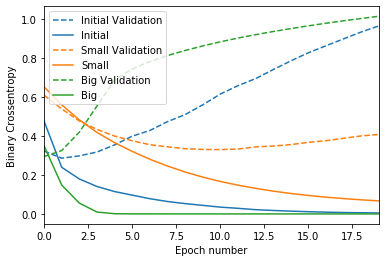

In [12]:
# To get a better visualization of the network architecture
# to the high variance issue, let's plot the metric/loss function
# as a function of the epoch number

def plot_histories(histories, metric='binary_crossentropy'):
    ''' Plot the metric as a function of the epoch number
        given the histories.
        The histories corresponding to the validation set
        are drawned with dashed lines. The histories corresponding to 
        the train set are drawned with solid lines.
        
        histories          histories along with their description (list of tuples)
        metrics            metrics to plot (string)
    '''
    
    for name, history in histories:
        # title() convert the 1st character of each word to an uppercase and the remaining ones to lowercase
        # plot() return a list of Lines representing the plotted data
        lines = plt.plot(history.epoch, history.history['val_' + metric], '--', label=(name + ' validation').title())
        # Plot the same metric with the same color
        plt.plot(history.epoch, history.history[metric], color=lines[0].get_color(), label=name.title())
    
    plt.xlabel('Epoch number')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    
    plt.xlim((0, history.epoch[-1]))
    plt.show()
    

# Plot the history of the metric 'binary crossentropy' for each network architecture
# and dataset

plot_histories([('Initial', initial_model_history),
               ('Small', small_model_history),
               ('Big', big_model_history)])
        
        

In [13]:
# Observation: The more complex the model is, the faster the model's cost function
# goes to 0 for the training set. A contrario, the more complex the model is,
# the faster the model overfits the training set.

### ADDRESS OVERFITTING
# REGULARIZATION: (Constraint weights to take only small values -> Less entropy)
# Make the distribution of the weights more 'regular'

# L1 Regularization: min(L1 norm of the weights)
# L2 Regularization: min(L2 norm of the weights), also called 'weight decay'

In [14]:
# Let's create a model with L2 regularization
# INPUT -> DENSE(16) -> RELU -> DENSE(16) -> RELU -> DENSE(1) -> SIGMOID


# kernel_regularizer = keras.regularizers.l2(0.001)
# -> Add L2 regularization term to the cost function, the parameters passed
# is called the regularization parameter. The higher this parameter is,
# the more important the effect of regularization will be

l2_model= keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer = keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(X_train,
                                Y_train,
                                epochs=20,
                                batch_size=512,
                                validation_data = (X_test, Y_test),
                                verbose=2)

# TO VERIFY:

# LOSS on TRAINING set: cost function + REGU (average at each BATCH end until end of EPOCH)
# LOSS on VALIDATION set: cost function + REGU (WHOLE set)
# METRIC on TRAINING set: cost function (average at each BATCH end until end of EPOCH)
# METRIC on VALIDATION set: cost function (WHOLE set)

# LOSS: Add the regularization term
# METRIC: Ignore the regularization term

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 5s - loss: 0.5274 - accuracy: 0.8025 - binary_crossentropy: 0.4898 - val_loss: 0.3847 - val_accuracy: 0.8698 - val_binary_crossentropy: 0.3463
Epoch 2/20
25000/25000 - 3s - loss: 0.3003 - accuracy: 0.9088 - binary_crossentropy: 0.2578 - val_loss: 0.3312 - val_accuracy: 0.8870 - val_binary_crossentropy: 0.2857
Epoch 3/20
25000/25000 - 3s - loss: 0.2472 - accuracy: 0.9307 - binary_crossentropy: 0.1993 - val_loss: 0.3365 - val_accuracy: 0.8848 - val_binary_crossentropy: 0.2866
Epoch 4/20
25000/25000 - 3s - loss: 0.2233 - accuracy: 0.9416 - binary_crossentropy: 0.1718 - val_loss: 0.3480 - val_accuracy: 0.8818 - val_binary_crossentropy: 0.2952
Epoch 5/20
25000/25000 - 3s - loss: 0.2080 - accuracy: 0.9473 - binary_crossentropy: 0.1538 - val_loss: 0.3605 - val_accuracy: 0.8789 - val_binary_crossentropy: 0.3053
Epoch 6/20
25000/25000 - 3s - loss: 0.1965 - accuracy: 0.9525 - binary_crossentropy: 0.1403 - val_loss: 0.3757

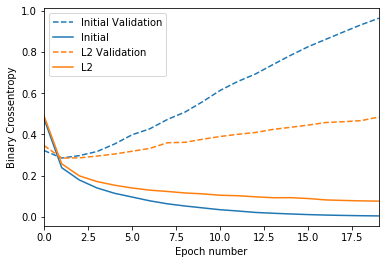

In [15]:
# Let's compare how the initial model overfits compared to the l2 model

plot_histories([('Initial', initial_model_history),
                ('l2', l2_model_history)])

# The l2-model does much better on the validation set

In [16]:
### ADDRESS OVERFITTING
# DROPOUT: (Constraint weights to take only small values -> Less entropy)

# Note that: At test time, no units are dropped out, and instead the layer's output values
# are scaled down by a factor equal to the dropout rate. (Instead of scaling up the layer's output
# values while training)

# INPUT -> DENSE(16) -> RELU -> DROPOUT -> DENSE(16) -> RELU -> DROPOUT -> DENSE(1) -> SIGMOID
dropout_model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5), # 0.5 is the fraction of entries zeroed-out
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dropout_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

dropout_model_history = dropout_model.fit(X_train,
                                          Y_train,
                                          epochs=20,
                                          batch_size=512,
                                          validation_data = (X_test, Y_test),
                                          verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 5s - loss: 0.6104 - accuracy: 0.6577 - binary_crossentropy: 0.6104 - val_loss: 0.4505 - val_accuracy: 0.8558 - val_binary_crossentropy: 0.4505
Epoch 2/20
25000/25000 - 3s - loss: 0.4285 - accuracy: 0.8168 - binary_crossentropy: 0.4285 - val_loss: 0.3207 - val_accuracy: 0.8788 - val_binary_crossentropy: 0.3207
Epoch 3/20
25000/25000 - 3s - loss: 0.3319 - accuracy: 0.8728 - binary_crossentropy: 0.3319 - val_loss: 0.2833 - val_accuracy: 0.8882 - val_binary_crossentropy: 0.2833
Epoch 4/20
25000/25000 - 3s - loss: 0.2773 - accuracy: 0.8955 - binary_crossentropy: 0.2773 - val_loss: 0.2775 - val_accuracy: 0.8857 - val_binary_crossentropy: 0.2775
Epoch 5/20
25000/25000 - 3s - loss: 0.2397 - accuracy: 0.9141 - binary_crossentropy: 0.2397 - val_loss: 0.2861 - val_accuracy: 0.8864 - val_binary_crossentropy: 0.2861
Epoch 6/20
25000/25000 - 3s - loss: 0.2128 - accuracy: 0.9233 - binary_crossentropy: 0.2128 - val_loss: 0.2866

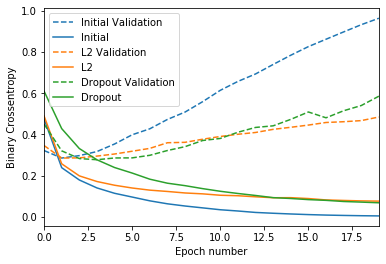

In [17]:
plot_histories([('Initial', initial_model_history),
                ('l2', l2_model_history),
                ('Dropout', dropout_model_history)])

In [ ]:
# As expected, adding dropout layers prevent the model from overfitting the training set.
# Regarding the validation accuracy, after 20 epochs, the DROPOUT model obtained: 0.875
#                                                     the L2 model obtained: 0.856
#                                                     the initial model obtained: 0.856

# TO ADDRESS OVERFITTING: 
# 1/ Get more data (data-augmentation for instance)
# 2/ Make the network architecture simpler (reduce the number of parameters)
# 3/ L1 or L2 regularization
# 4/ Dropout
# 5/ Batch normalization(covariance invariance)